In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functions 
import seaborn as sns 
from time import time

import pandas as pd 
import seaborn as sns
from sklearn.neighbors import NearestNeighbors 

from matplotlib import cm

plt.rcParams.update({'font.size': 14})

cmap = cm.get_cmap('tab20c')
y1_color = cmap(1/20) #blue
y2_color = cmap(6/20) #orange
y3_color = cmap(9/20) #green
y4_color = cmap(14/20) #purple



/var/folders/wb/j_66l1b92d580qv2dsc3kpmr0000gp/T/ipykernel_3035/3222589378.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')


# 1st METHOD NON-ADAPTIVE TO THE COVARIATES X  
### i.e. treating scores independently of X 

The next cell defines functions to compare MK quantiles and regions of prescribed shapes: ellipsoid / hyperrectangle. 

In [ ]:

from matplotlib.patches import Rectangle 

def get_rectangle(scores,alpha): 
    marginal_alpha = np.sqrt(alpha) 
    center_outward_m = (1 - marginal_alpha)/2  
    axis0 = np.quantile(scores.T[0],[1-center_outward_m,center_outward_m]) 
    axis1 = np.quantile(scores.T[1],[1-center_outward_m,center_outward_m]) 
    hyperrectangle = Rectangle((axis0[0],axis1[0]), axis0[1]-axis0[0], axis1[1]-axis1[0],
                               fill=False,color=y2_color,linewidth=3,linestyle='--') 
    return(hyperrectangle)

def get_vol_rectangle(scores,alpha):
    marginal_alpha = np.sqrt(alpha)
    center_outward_m = (1 - marginal_alpha)/2 
    prod = 1 
    for j in range(scores.shape[1]):
        borders = np.quantile(scores.T[j],[1-center_outward_m,center_outward_m])
        #print(borders)
        prod = prod * (borders[0]-borders[1])
    return(prod)


def matrix_to_param(mat):
    """
    Function taken from https://github.com/M-Soundouss/EllipsoidalConformalMTR/tree/main. 
    Calculates an ellipse's parameters to draw it as in https://cookierobotics.com/007/
    :param mat: Covariance matrix
    :return: Ellipse's parameters
    """
    lambda1 = (mat[0, 0] + mat[1, 1]) / 2 + np.sqrt(
        ((mat[0, 0] - mat[1, 1]) / 2) ** 2 + mat[0, 1] ** 2
    )
    lambda2 = (mat[0, 0] + mat[1, 1]) / 2 - np.sqrt(
        ((mat[0, 0] - mat[1, 1]) / 2) ** 2 + mat[0, 1] ** 2
    )

    if mat[0, 1] == 0 and mat[0, 0] >= mat[1, 1]:
        theta = 0
    elif mat[0, 1] == 0 and mat[0, 0] < mat[1, 1]:
        theta = np.pi / 2
    else:
        theta = np.arctan2(lambda1 - mat[0, 0], mat[0, 1])

    return np.sqrt(lambda1), np.sqrt(lambda2), theta

from math import degrees
from matplotlib.patches import Ellipse

def get_ellipse(scores,alpha):
    cov = np.cov(scores.T)
    cov_1 = np.linalg.inv(cov)
    MahalanobisNCM = -np.ones(len(scores)) # Mahalanobis Non-Conformity Measure
    for k in range(len(scores)):
        MahalanobisNCM[k] = scores[k].T @ cov_1 @ scores[k]
    OrderStatistics = np.argsort(MahalanobisNCM)
    q = alpha *(1+1/len(scores))
    indexTreshold = OrderStatistics[(int(q*len(scores))+1)]
    alpha_s = MahalanobisNCM[indexTreshold]
    width, height, theta = matrix_to_param(cov * alpha_s )
    ellipsis = Ellipse(
            xy=(0,0),
            width = 2 * width,
            height = 2 * height,
            angle = degrees(theta),
            linewidth=3,
            color="lightpink",
            fill=False
        )
    return(ellipsis)

from scipy.special import gamma

def get_vol_ellipse(scores,alpha):
    cov = np.cov(scores.T)
    cov_1 = np.linalg.inv(cov)
    MahalanobisNCM = -np.ones(len(scores)) # Mahalanobis Non-Conformity Measure
    for k in range(len(scores)):
        MahalanobisNCM[k] = scores[k].T @ cov_1 @ scores[k]
    OrderStatistics = np.argsort(MahalanobisNCM)
    q = alpha *(1+1/len(scores))
    indexTreshold = OrderStatistics[(int(q*len(scores))+1)]
    alpha_s = MahalanobisNCM[indexTreshold]
    d = scores.shape[1] # The number of dimensions
    volume_unit_ball = np.pi**(d/2) / gamma(d/2 + 1)
    return( np.linalg.det( cov*alpha_s )**(1/2) * volume_unit_ball )


For our example on simulated data, we consider the following mixture of Gaussians as the distribution of the noise around the prediction $\hat{f}$. 

volume of MK region: 1.1895413984933632
volume rectangle: 1.3843904197682695
volume ellipse: 1.3585442252768014


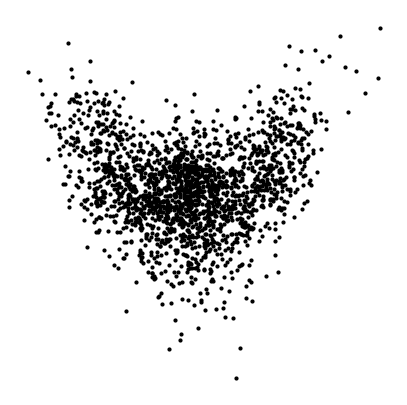

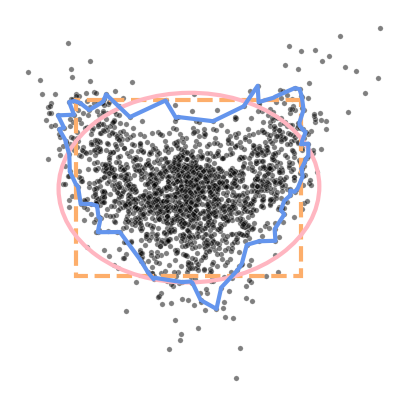

In [3]:
def sample_scores(n = 800):
    S1 = np.array([[6,-4],[-4,6]])
    S2 = np.array([[6,4],[4,6]])
    S3 = np.array([[2,0],[0,2]])
    Y1 = np.random.multivariate_normal([-4.5,0],S1,int(n*1/3))
    Y2 = np.random.multivariate_normal([4.5,0],S2,int(n*1/3))
    Y3 = np.random.multivariate_normal([0,0],S3,n-2*int(n*1/3))
    scores  = np.concatenate([Y1,Y2,Y3])
    idx = np.arange(len(scores)) 
    np.random.shuffle(idx) 
    scores = scores[idx] 
    return(scores) 


np.random.seed(62)

scores = sample_scores(n=2000)/10

sns.set_style("white")
# Plot: 
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(scores[:,0],scores[:,1],c="black",s=4)
plt.axis("off")


#
alpha = 0.9

# MK quantile region :
Quantile_Treshold,mu,psi,psi_star,data_calib = functions.MultivQuantileTreshold(scores,alpha=alpha) # solve OT 
contourMK = functions.get_contourMK(Quantile_Treshold,psi_star,data_calib)
print("volume of MK region:", functions.get_volume_QR(Quantile_Treshold,mu,psi,scores) )

# HYPERRECTANGLES : 
hyperrectangle = get_rectangle(scores,alpha)
print("volume rectangle:", get_vol_rectangle(scores,alpha) )

# ELLIPSOIDAL :
ellipsis = get_ellipse(scores,alpha)
print("volume ellipse:", get_vol_ellipse(scores,alpha) )


sns.set_style("white")


# Plot: 
fig, ax = plt.subplots(figsize=(5,5))
df = pd.DataFrame(scores,columns=["X1","X2"])
sns.scatterplot(df,x="X1",y="X2",c="black",s=15,alpha=0.5)#,c=ranksMK) 
plt.plot(contourMK.T[0],contourMK.T[1],color='cornflowerblue',linewidth=3)
#plt.scatter(Score_treshold[0],Score_treshold[1],c="red",s=100,marker="+") 
ax.add_patch(hyperrectangle)
ax.add_patch(ellipsis)
plt.axis("off")
plt.savefig("Figures/quantiles_scores.pdf", format="pdf", bbox_inches="tight")

Now that we have the functions to compute volumes, we can repeat experiments to compare efficiency and coverage. 

## Comparison of coverage and efficiency

In [ ]:


from sklearn.model_selection import train_test_split

def LearnParameters(scores,alpha):
    ''' Learn parameters for MK quantiles, hyperrectangles, and ellipsoids. scores = data on which quantiles are computed. alpha = quantile level. '''
    #############################################
    ### MK : 
    t0 = time()
    Quantile_Treshold,mu,psi,psi_star,data_calib = functions.MultivQuantileTreshold(scores,alpha=alpha)
    timeMK = np.round(time()-t0,3) 
    ############################################# 
    ### Ellipsoids: 
    t0 = time()
    data_calib, data_valid = train_test_split(scores,test_size=0.25) 
    # learn covariance on data calib
    cov = np.cov(data_calib.T)
    # compute treshold on data valid
    cov_1 = np.linalg.inv(cov)
    MahalanobisNCM = -np.ones(len(data_valid)) # Mahalanobis Non-Conformity Measure
    for k in range(len(data_valid)):
        MahalanobisNCM[k] = data_valid[k].T @ cov_1 @ data_valid[k]
    n = len(data_valid)
    alpha_s = np.quantile( MahalanobisNCM, np.min(  [np.ceil((n+1)*alpha)/n ,1] )   ) 

    timeMaha = np.round(time()-t0,3) 
    ############################################# 
    ### Hyperrectangles : 
    t0 = time()
    d = scores.shape[1]
    componentwise_alpha = 1-(1-alpha)/d 
    center_outward_m = (1 - componentwise_alpha)/2  
    list_axis = []
    for k in range(d):
        axis = np.quantile(scores.T[k],[1-center_outward_m,center_outward_m]) 
        list_axis.append(axis) 
    list_axis = np.array(list_axis)
    timeRECT = np.round(time()-t0,3) 

    times = np.array([timeMK,timeMaha,timeRECT])
    return(Quantile_Treshold,mu,psi,psi_star,alpha_s,cov,cov_1,list_axis,times)




0
0.287
1
0.319
2
0.267
3
0.291
4
0.286
5
0.269
6
0.282
7
0.273
8
0.294
9
0.261
10
0.284
11
0.295
12
0.269
13
0.272
14
0.261
15
0.252
16
0.267
17
0.285
18
0.27
19
0.277
20
0.269
21
0.295
22
0.276
23
0.285
24
0.27
25
0.265
26
0.285
27
0.266
28
0.272
29
0.286
30
0.294
31
0.269
32
0.285
33
0.296
34
0.271
35
0.265
36
0.281
37
0.268
38
0.278
39
0.278
40
0.28
41
0.277
42
0.291
43
0.281
44
0.281
45
0.282
46
0.262
47
0.259
48
0.269
49
0.278


<Figure size 640x480 with 0 Axes>

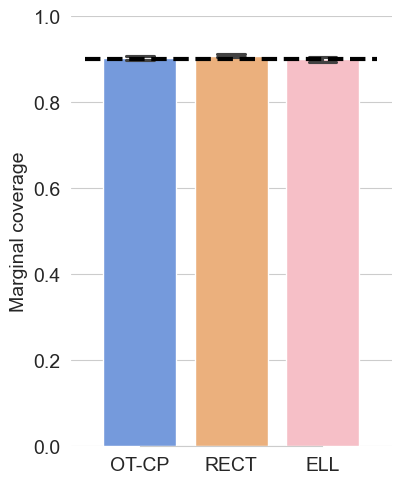

<Figure size 640x480 with 0 Axes>

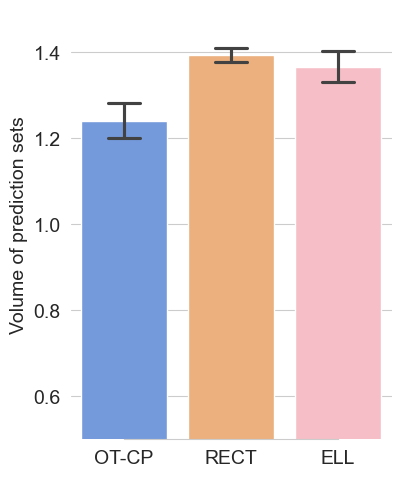

<Figure size 640x480 with 0 Axes>

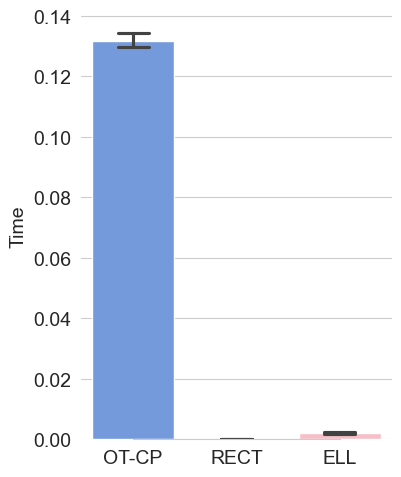

In [5]:
np.random.seed(62)

alpha = 0.9

#############################################
rates_cvg_MK = []
rates_cvg_rect = []
rates_cvg_ell = []
volumes_MK = []
volumes_rect = []
volumes_ell = [] 
computational_time_MK = []
computational_time_rect = []
computational_time_ell = []

for rep in range(50): 
    t0 = time()
    print(rep)
    # Sample calibration data
    scores_cal = sample_scores(n=1000)/10 
    Quantile_Treshold,mu,psi,psi_star,alpha_s,cov,cov_1,list_axis,times = LearnParameters(scores_cal,alpha)
    computational_time_MK.append( times[0] )
    computational_time_ell.append( times[1] )
    computational_time_rect.append( times[2] )
    scores_test = sample_scores(n=1000)/10 
    # Compute MK quantile region coverage
    RankMK = functions.RankFunc(scores_test, mu, psi) 
    norm_RankMK = np.linalg.norm(RankMK, axis=1)
    coverageMK = np.mean(norm_RankMK <= Quantile_Treshold)

    # Compute hyperrectangle coverage
    within_lower_bounds = np.all(list_axis.T[1] <= scores_test, axis=1)
    within_upper_bounds = np.all(scores_test <= list_axis.T[0], axis=1)
    coverageRectangle = np.mean(within_lower_bounds & within_upper_bounds)

    # Compute Ellipse coverage
    MahalanobisNCM = np.einsum('ij,ji->i', scores_test @ cov_1, scores_test.T)
    # Efficient Mahalanobis calculation
    coverageEllipse = np.mean(MahalanobisNCM <= alpha_s)
    # Gather results
    rates_cvg_MK.append(coverageMK)
    rates_cvg_rect.append(coverageRectangle)
    rates_cvg_ell.append(coverageEllipse)

    # Volumes :
    # MK :
    volumes_MK.append(functions.get_volume_QR(Quantile_Treshold,mu,psi,scores_cal,N = len(scores_test))) 
    # Rectangle: 
    lengths_sides = list_axis.T[0]-list_axis.T[1]
    volumes_rect.append( np.prod(lengths_sides)  )
    # Ellipse: 
    d = scores_test.shape[1] # The number of dimensions
    volume_unit_ball = np.pi**(d/2) / gamma(d/2 + 1)
    volumes_ell.append( np.linalg.det( cov*alpha_s )**(1/2) * volume_unit_ball )
    print(np.round(time()-t0,3) )

rates_cvg_MK = np.array(rates_cvg_MK)  
rates_cvg_rect = np.array(rates_cvg_rect)  
rates_cvg_ell = np.array(rates_cvg_ell)  
volumes_MK = np.array(volumes_MK)  
volumes_rect = np.array(volumes_rect)  
volumes_ell = np.array(volumes_ell)  
computational_time_MK = np.array(computational_time_MK)
computational_time_rect = np.array(computational_time_rect)
computational_time_ell = np.array(computational_time_ell)
#################################################################################
sns.set_style("whitegrid")

to_boxplot = np.array([rates_cvg_MK,rates_cvg_rect,rates_cvg_ell]).T  
df = pd.DataFrame(to_boxplot,columns=(["OT-CP","RECT","ELL"])) 
plt.figure()
g =sns.catplot( 
    data=df,  kind="bar",palette=["cornflowerblue",y2_color,"lightpink"],aspect=.8,capsize=0.3
    )   
plt.hlines(alpha,xmin=-0.6,xmax=2.6,linewidth=3,linestyles="dashed",color="black") 
plt.ylim(0,1)
sns.despine(trim=True, left=True)
plt.ylabel("Marginal coverage") 
plt.savefig("Figures/Coverage_reg_simu.pdf", format="pdf",bbox_inches="tight")
plt.show()

#################################################################################
to_boxplot = np.array([volumes_MK,volumes_rect,volumes_ell]).T  
df = pd.DataFrame(to_boxplot,columns=(["OT-CP","RECT","ELL"])) 

plt.figure()
g =sns.catplot( 
    data=df,  kind="bar",palette=["cornflowerblue",y2_color,"lightpink"],aspect=0.8,capsize=0.3
    )   
sns.despine(trim=True, left=True)
plt.ylabel("Volume of prediction sets")  
plt.ylim(0.5,1.5)
plt.savefig("Figures/Efficiency_reg_simu.pdf", format="pdf",bbox_inches="tight")
plt.show()

#################################################################################
to_boxplot = np.array([computational_time_MK,computational_time_rect,computational_time_ell]).T  
df = pd.DataFrame(to_boxplot,columns=(["OT-CP","RECT","ELL"])) 

plt.figure()
g =sns.catplot( 
    data=df,  kind="bar",palette=["cornflowerblue",y2_color,"lightpink"],aspect=0.8,capsize=0.3
    )   
sns.despine(trim=True, left=True)
plt.ylabel("Time")  
plt.savefig("Figures/Time_reg_simu.pdf", format="pdf",bbox_inches="tight")
plt.show()

#### All the previous computations have been made on scores (independently of $X$). 

#### The next cell uses codes for quantile regression to visualize the impact in terms of prediction regions (around a prediction $\hat{f}$)

In [6]:
def PlotQuantile3D(x , y, z,quantile, quantile2,quantile3,center,NumberOfGrid,ContourLength):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    ax.scatter3D(x, y, z, color='gray',s=30,alpha=0.2,label="Test samples")
    ax.set_xlabel('X',fontsize=15)
    ax.set_ylabel('$Y_1$',fontsize=15)
    ax.set_zlabel('$Y_2$',fontsize=15)
    #Plot the centers 
    ax.plot3D(center[:,0],center[:,1],center[:,2], 'black',alpha = 1, 
              linewidth=3.0,linestyle='-.',zorder=5,label="Prediction $\hat{f}(x)$")
    for k in range(NumberOfGrid):
        si=ContourLength
        r1=k*(si)
        r2=(si)*(k+1)
        q1=np.zeros((si+1,3))
        q1[0:si,:]=quantile[r1:r2,:]
        q1[si,:]=quantile[r1,:]
        q1=np.zeros((si+1,3))
        q1[0:si,:]=quantile2[r1:r2,:]
        q1[si,:]=quantile2[r1,:]
        q1=np.zeros((si+1,3))
        q1[0:si,:]=quantile3[r1:r2,:]
        q1[si,:]=quantile3[r1,:]
        if k==0:
            ax.plot3D(q1[:,0],q1[:,1],q1[:,2],'cornflowerblue',alpha = 1, linewidth=2.0,zorder=2,label="MK prediction sets")
        else:
            ax.plot3D(q1[:,0],q1[:,1],q1[:,2],'cornflowerblue',alpha = 1, linewidth=2.0,zorder=2)
    ax.set_box_aspect(None, zoom=0.9)
    plt.legend(loc='center left', bbox_to_anchor=(0.13, 0.75))
    

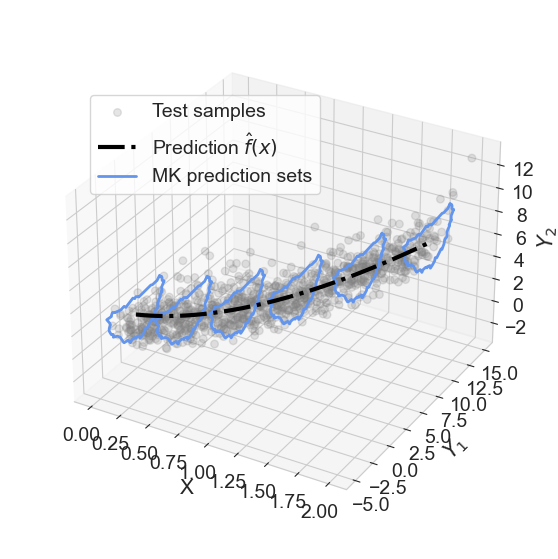

In [ ]:
np.random.seed(62)

n_sample = 999
x = np.linspace(0,2,n_sample)
noise = sample_scores(n_sample)/2

Y = np.array([ 2*x**2, (x+1)**2]).T + noise
y = Y.T[0]
z = Y.T[1]
k = 100 # number of points in a contour 
grid = 6
levels = np.array([0.2,0.5,0.8])

### predictor
BayesRegressor = np.array([x, 2*x**2, (x+1)**2]).T 

### Quantile computation 
d = Y.shape[1]
scores = Y - BayesRegressor[:,1:]
U = functions.sample_grid(scores)
psi, psi_star = functions.learn_psi(U,scores)

sphere = np.array([np.cos(2*np.pi*np.arange(k)/k),np.sin(2*np.pi*np.arange(k)/k)]).T
quantile_contours = []
for alpha in levels:
    quantile_contours.append( functions.T0(alpha*sphere , scores ,psi_star) )
quantile_contours = np.array(quantile_contours)

### x mesh
indices_grid = np.array( np.linspace(0,0.999,grid)*len(x) ,dtype=int)
x_tick = x[indices_grid]

quantiles = []
for i in range(len(levels)):
    g = 0
    Q0 = quantile_contours[i] + BayesRegressor[:,1:][indices_grid][g] 
    BayesRegressor[indices_grid] 
    quantile1 = np.array([np.repeat(x_tick[g] ,k),Q0.T[0],Q0.T[1]]).T 
    for g in range(1,grid):
        Q0 = quantile_contours[i] + BayesRegressor[:,1:][indices_grid][g] 
        Q0x = np.array([np.repeat(x_tick[g] ,k),Q0.T[0],Q0.T[1]]).T 
        quantile1 = np.concatenate([quantile1,Q0x])
    quantiles.append(quantile1)
quantile1, quantile2, quantile3 = quantiles 

PlotQuantile3D(x,y,z,quantile1, quantile2, quantile3, BayesRegressor,grid,k) 
plt.savefig("Figures/HomoscedasticNoise.pdf", format="pdf",bbox_inches="tight") 
plt.show()

 We now turn to adaptive regions via quantile regression on scores 
 
 # ADAPTIVE VERSION : OT-CP+


We begin with an example with $X\in\mathbb{R}$ and $Y\in\mathbb{R}^2$, in order to vizualise the results.


In [8]:
def ConformalQuantileKn(x, y, n, x_tick,k,alpha):
    ''' To plot quantile contours with 3D visualisation, OT-CP+ '''
    ### x=covariates 
    ### y=output variables
    ### n= number of neighbors 
    ### x_tick = list of points x where the conditional quantile function Q( . / X = x) is to be computed 
    ### k number of points in quantile contour
    ### levels : contour levels to be computed, each between 0 and 1 

    x = np.array(x)
    y = np.array(y)    

    ## uniform grid
    d = y.shape[1]
    U = functions.sample_grid(np.zeros((n,d)))

    quantile_contours = []
    ## Compute quantile contours, for each x
    for i in range(len(x_tick)):
        X = np.zeros(n)
        ### select n-nearest neighbors
        order = np.argsort(np.linalg.norm(x-x_tick[i],axis=1) )
        scores = scores[order][:n]

        Quantile_Treshold,mu,psi,psi_star,data_calib = functions.MultivQuantileTreshold(scores,alpha=alpha)
        
        sphere = np.array([np.cos(2*np.pi*np.arange(k)/k),np.sin(2*np.pi*np.arange(k)/k)]).T
        quantile_contours.append( functions.T0(Quantile_Treshold*sphere , scores ,psi_star) ) 
    return(np.array(quantile_contours)) 

def get_metricsMK(newdata,mu,psi,Quantile_Treshold,scores):
    # Compute MK quantile region coverage :
    RanksMK = functions.RankFunc(newdata, mu, psi) 
    norm_RankMK = np.linalg.norm(RanksMK, axis=1)
    coverageMK = np.mean(norm_RankMK <= Quantile_Treshold)
    # Compute volume of MK quantile region :
    volumeMK = functions.get_volume_QR(Quantile_Treshold,mu,psi,scores) 
    return(coverageMK,volumeMK) 

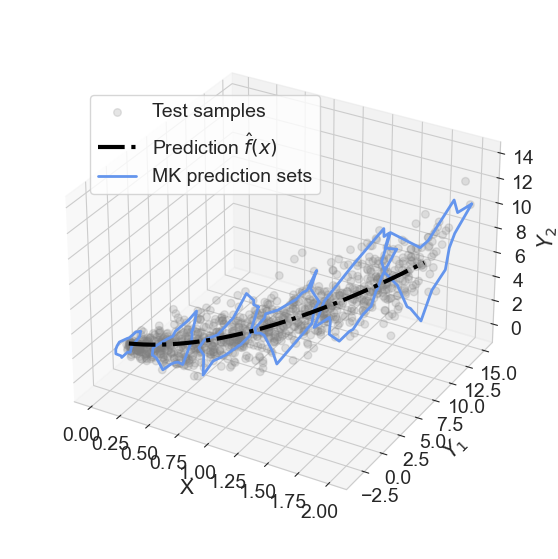

In [9]:
np.random.seed(123)

n_sample = 999
x = np.linspace(0,2,n_sample)
noise2 = sample_scores(n_sample)/2
Y = np.array([ 2*x**2, (x+1)**2]).T  + noise2*np.sqrt(x).reshape(n_sample,1)
y = Y.T[0] 
z = Y.T[1] 
n = 100 # number of neighbors

k = 100 # number of points in a contour 
grid = 6
alpha = 0.9

### predictor
BayesRegressor = np.array([x, 2*x**2, (x+1)**2]).T 

### Quantile computation 
d = Y.shape[1] 
U = functions.sample_grid(np.zeros((n,d)))  

### x mesh
indices_grid = np.array( np.linspace(0,0.999,grid)*len(x) ,dtype=int) 
x_tick = x[indices_grid] 

sphere = np.array([np.cos(2*np.pi*np.arange(k)/k),np.sin(2*np.pi*np.arange(k)/k)]).T 
quantile_contours = [] 
for i in range(grid): 
    ### select n-nearest neighbors  
    scores = Y - BayesRegressor[:,1:] 
    order = np.argsort(np.abs(x-x_tick[i]) ) 
    scores = scores[order][:n] 
    # Solve OT 
    Quantile_Treshold,mu,psi,psi_star,data_calib = functions.MultivQuantileTreshold(scores,alpha=alpha)
    # Compute quantile contour 
    Q0 = functions.T0(Quantile_Treshold*sphere , data_calib ,psi_star) 
    quantile_contours.append( Q0 ) 
quantile_contours = np.array(quantile_contours) 

quantiles = []
g = 0 
Q0 = quantile_contours[g] + BayesRegressor[:,1:][indices_grid][g] 
BayesRegressor[indices_grid] 
quantile1 = np.array([np.repeat(x_tick[g] ,k),Q0.T[0],Q0.T[1]]).T 
for g in range(1,grid):
    Q0 = quantile_contours[g] + BayesRegressor[:,1:][indices_grid][g] 
    Q0x = np.array([np.repeat(x_tick[g] ,k),Q0.T[0],Q0.T[1]]).T 
    quantile1 = np.concatenate([quantile1,Q0x])

quantile1, quantile2, quantile3 = quantile1,quantile1,quantile1 

PlotQuantile3D(x,y,z,quantile1, quantile2, quantile3, BayesRegressor,grid,k) 
plt.savefig("Figures/HeteroscedasticNoise.pdf", format="pdf",bbox_inches="tight")
plt.show()

We now evaluate conditional coverage on this toy-example. 

In [14]:
np.random.seed(321)

n_sample = 999 

alpha = 0.9 
Nrep = 30 # Proportion of test data in the prediction region is repeated `Nrep`` times 
n_test = 300 # n_test new data points in testing data 
k = 100 #  # number of neigbors to compute Quantile regression function   

####### SAMPLE CALIBRATION DATA AND LEARN CONFORMAL CONDITIONAL QUANTILE FUNCTION 
x = np.linspace(0,2,n_sample) 
noise2 = sample_scores(n_sample)/2 
y = np.array([ 2*x**2, (x+1)**2]).T  + noise2*np.sqrt(x).reshape(n_sample,1)
BayesRegressor = np.array([2*x**2, (x+1)**2]).T 
scores_cal = y - BayesRegressor 
x = x.reshape(-1, 1)  # customary for knn 

Quantile_Treshold,knn,scores_cal_1,mu = functions.MultivQuantileTreshold_Adaptive(scores_cal,x,n_neighbors=k,alpha = alpha)

########################################################
####### Assess coverage on an interval (a,b)
########################################################
a,b = 0.25,0.5 # interval on which to sample the test data 
res = - np.ones(Nrep)
for rep in range(Nrep):
    ####### SAMPLE TEST DATA IN THE INTERVAL (a,b) and compute scores on this test data
    X_test = np.linspace(a,b,n_test)
    noise2 = sample_scores(n_test)/2
    Y_test =  np.array([ 2*X_test**2, (X_test+1)**2]).T  + noise2*np.sqrt(X_test).reshape(n_test,1)
    BayesRegressor = np.array([2*X_test**2, (X_test+1)**2]).T 
    Stest = Y_test - BayesRegressor

    ####### Conformal multivariate regression 
    coverage_conditional_X_test = []
    for i,x_tick in enumerate(X_test): # for each new testing point x_tick 
        ConditionalRank,psi,Y = functions.ConditionalRank_Adaptive(Stest[i],x_tick,knn,scores_cal_1,n_neighbors=k,mu=mu)
        coverage_conditional_X_test.append( 1*(np.linalg.norm(ConditionalRank) <= Quantile_Treshold) ) # verify if the test data points belongs to the quantile region
    coverage_conditional_X_test = np.array(coverage_conditional_X_test) 
    res[rep] = np.mean( coverage_conditional_X_test )
res1 = res

print("1 ok ")

########################################################
####### Assess coverage on an another interval (a,b)
########################################################
a,b = 1.5,2 # interval on which to sample 
res = - np.ones(Nrep)
for rep in range(Nrep):
    ####### SAMPLE TEST DATA IN THE INTERVAL (a,b) and compute scores on this test data
    X_test = np.linspace(a,b,n_test)
    noise2 = sample_scores(n_test)/2
    Y_test =  np.array([ 2*X_test**2, (X_test+1)**2]).T  + noise2*np.sqrt(X_test).reshape(n_test,1)
    BayesRegressor = np.array([2*X_test**2, (X_test+1)**2]).T 
    Stest = Y_test - BayesRegressor

    ####### Conformal multivariate regression 
    coverage_conditional_X_test = []
    for i,x_tick in enumerate(X_test): # for each new testing point x_tick 
        ConditionalRank,psi,Y = functions.ConditionalRank_Adaptive(Stest[i],x_tick,knn,scores_cal_1,n_neighbors=k,mu=mu)
        coverage_conditional_X_test.append( 1*(np.linalg.norm(ConditionalRank) <= Quantile_Treshold) ) # verify if the test data points belongs to the quantile region
    coverage_conditional_X_test = np.array(coverage_conditional_X_test) 
    res[rep] = np.mean( coverage_conditional_X_test )
res2 = res

print("2 ok ")

########################################################
####### Assess coverage on an another interval (a,b)
########################################################
a,b = 0,2 # interval on which to sample 
res = - np.ones(Nrep)
for rep in range(Nrep):
    ####### SAMPLE TEST DATA IN THE INTERVAL (a,b) and compute scores on this test data
    X_test = np.linspace(a,b,n_test)
    noise2 = sample_scores(n_test)/2
    Y_test =  np.array([ 2*X_test**2, (X_test+1)**2]).T  + noise2*np.sqrt(X_test).reshape(n_test,1)
    BayesRegressor = np.array([2*X_test**2, (X_test+1)**2]).T 
    Stest = Y_test - BayesRegressor

    ####### Conformal multivariate regression 
    coverage_conditional_X_test = []
    for i,x_tick in enumerate(X_test): # for each new testing point x_tick 
        ConditionalRank,psi,Y = functions.ConditionalRank_Adaptive(Stest[i],x_tick,knn,scores_cal_1,n_neighbors=k,mu=mu)
        coverage_conditional_X_test.append( 1*(np.linalg.norm(ConditionalRank) <= Quantile_Treshold) ) # verify if the test data points belongs to the quantile region
    coverage_conditional_X_test = np.array(coverage_conditional_X_test) 
    res[rep] = np.mean( coverage_conditional_X_test )
resmarginal = res


1 ok 
2 ok 


/var/folders/wb/j_66l1b92d580qv2dsc3kpmr0000gp/T/ipykernel_24048/1277905156.py:5: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g =sns.catplot(


<Figure size 640x480 with 0 Axes>

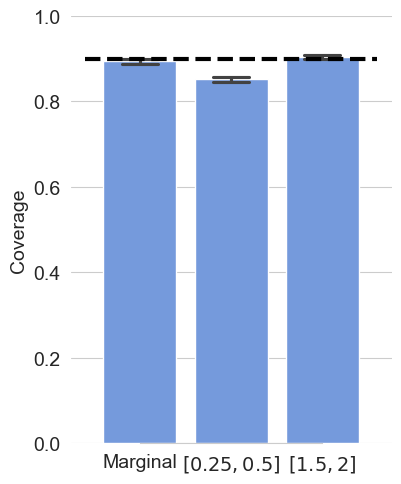

In [15]:
to_boxplot = np.array([resmarginal,res1,res2]).T  
df = pd.DataFrame(to_boxplot,columns=(["Marginal","$[0.25,0.5]$","$[1.5,2]$"])) 

plt.figure()
g =sns.catplot( 
    data=df,  kind="bar",palette=["cornflowerblue"],aspect=.8,capsize=0.4
)   
plt.hlines(alpha,xmin=-0.6,xmax=2.6,linewidth=3,linestyles="dashed",color="black") 
plt.ylim(0,1)
sns.despine(trim=True, left=True)
plt.ylabel("Coverage") 
plt.savefig("Figures/SimuConditionalCVG.pdf", format="pdf",bbox_inches="tight")
plt.show()

## OT-CP+ requires more computations: 

In [ ]:
list_n = [1000,2000,3000,4000,5000,6000]
MeanTimeMK = []
MeanTimeRECT = []
MeanTimeELL = []
MeanTimeMKplus = []

np.random.seed(62)

for n in list_n:
    print(n)
    alpha = 0.9
    #############################################
    computational_time_MK = []
    computational_time_rect = []
    computational_time_ell = []

    for rep in range(10): 
        # Sample calibration data 
        scores_cal = sample_scores(n)/10 
        Quantile_Treshold,mu,psi,psi_star,alpha_s,cov,cov_1,list_axis,times = LearnParameters(scores_cal,alpha)
        computational_time_MK.append( times[0] )
        computational_time_ell.append( times[1] )
        computational_time_rect.append( times[2] )

        t0 = time()
        x_cal = np.linspace(0,2,n).reshape(-1, 1) #x_cal has a single feature 
        Quantile_Treshold,knn,scores_cal_1,mu = functions.MultivQuantileTreshold_Adaptive(scores_cal,x_cal,n_neighbors=int(n/10),alpha = alpha)
        computational_time_MKadaptive = np.round( time() -t0 ,3)

    MeanTimeMK.append( np.array(computational_time_MK).mean() )
    MeanTimeRECT.append( np.array(computational_time_rect).mean() )
    MeanTimeELL.append(  np.array(computational_time_ell).mean() )
    MeanTimeMKplus.append( np.array(computational_time_MKadaptive).mean() )

#df_results_time = pd.DataFrame(np.array([MeanTimeMK,MeanTimeRECT,MeanTimeELL ]).T,columns=["OT-CP","RECT","ELL"]) 
df_results_time = pd.DataFrame(np.array([ MeanTimeMK,MeanTimeMKplus ]).T,columns=["OT-CP","OT-CP+"]) 

#df_results_time = pd.DataFrame(np.array([MeanTimeMK,MeanTimeRECT,MeanTimeELL ]).T,columns=["OT-CP","RECT","ELL"]) 
df_results_time = pd.DataFrame(np.array([ MeanTimeMK,MeanTimeMKplus ]).T,columns=["OT-CP","OT-CP+"],index=list_n[:6]) 

sns.scatterplot(data=df_results_time,s=100)
sns.lineplot(data=df_results_time,legend=False)
plt.ylabel("Time (seconds)")
plt.xlabel("Size of calibration data")
plt.savefig("TimeOTCP.pdf")

# Analysis of Real data 

In [11]:
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [12]:
########### LOAD DATA 

list_data = ["enb","atp1d","jura","rf1","wq","scm20d","oes10","oes97"] 
dim_targets =  [2,6,7,8,14,16,16,16]
#list_data = ["andro","slump"] 
#dim_targets =  [6,3]

m = 5

arff_file = arff.loadarff('./data/{}.arff'.format(list_data[m])) 
df = pd.DataFrame(arff_file[0]).dropna()
print(df.head()) 

## Extract target variable y 
df = np.array(df) 
tt = df.shape[1] - dim_targets[m]
x = df[:,:tt] 
y = df[:,tt:] 
print("Amount of data:", x.shape,y.shape) 


   timeunit  storageCost  interestRate  compidx0lt2  compidx4lt2  compidx6lt2  \
0       9.0         27.0           8.0      881.606      276.589      283.096   
1      10.0         27.0           8.0      869.455      288.277      271.252   
2      11.0         27.0           8.0      850.916      288.429      271.573   
3      12.0         27.0           8.0      862.066      290.866      268.637   
4      13.0         27.0           8.0      842.781      278.185      270.078   

   compidx8lt2  compidx10lt2  compidx12lt2  compidx14lt2  ...  MTLp7A  MTLp8A  \
0      113.193       108.831       247.377       228.541  ...  1747.0  1905.0   
1      116.232       109.822       250.485       222.397  ...  1794.0  2060.0   
2      116.703       108.636       252.319       218.822  ...  1774.0  1876.0   
3      117.098       109.253       257.071       204.266  ...  1760.0  1820.0   
4      116.822       105.997       257.858       213.514  ...  1780.0  1846.0   

   MTLp9A  MTLp10A  MTLp11

### The next cell defines the needed functions for MK conditional quantiles :

In [13]:

def SetCoverage(Xtest,Stest,parameters_MK):
    ''' 
    Computes coverage and volume of MK quantile region. 
     - parameters_MK = parameters for calibrated MK conditional quantiles.
     - Xtest and Stest = test data, on which to evaluate empirical coverage . 
    '''

    Quantile_Treshold,knn,scores_cal_1,mu = parameters_MK 
    n = knn.get_params()["n_neighbors"]

    prop = 0
    average_volume = 0
    for i in range(len(Xtest)):
        ConditionalRank,psi,Y = functions.ConditionalRank_Adaptive(Stest[i],Xtest[i] ,knn,scores_cal_1,n_neighbors=n,mu=mu)

        indic_content = 1*(np.linalg.norm(ConditionalRank) <= Quantile_Treshold)  #Ytest is in prediction region if Stest is in quantile region. 

        volume_QR = functions.get_volume_QR(Quantile_Treshold,mu,psi,Y) 
        prop += indic_content 
        average_volume += volume_QR
    prop = prop / len(Xtest)
    average_volume = average_volume / len(Xtest)
    return(prop,average_volume)

def WorstSetCoverage(Xtest,Stest,parameters_MK,n=100):
    '''
    This functions selects 5 random subsets Ai of Xtest, on which it estimates conditional coverage, before taking the minimal coverage value (the worst case scenario). 
    Each subset Ai is selected by a random choice of point (and its n neighbors) within Xtest. 

    - Xtest and Stest = test data, on which to evaluate empirical coverage  
    - n = number of points in subset Ai 
    - parameters_MK = parameters for calibrated MK conditional quantiles. 
    '''

    # choice of some points in Xtest, that will serve as centers to define subsets 
    random_idx = np.random.randint(len(Xtest),size=5) 
    # For each, define a neighborood Ai and compute empirical coverage on it 
    list_coverage_Ai = - np.ones(len(random_idx))
    list_average_volume_Ai = - np.ones(len(random_idx))
    for i,idx in enumerate(random_idx):
        ### select nn-nearest neighbors
        if len(x.shape)>1:
            norms_ranks = np.linalg.norm(Xtest-Xtest[idx],axis=1)
        else:
            norms_ranks = np.abs(Xtest-Xtest[idx])
        order = np.argsort(norms_ranks )
        Ai = Xtest[order][:n] 
        Scores_Ai = Stest[order][:n] 
        Coverage_Ai,average_volume = SetCoverage(Xtest=Ai,Stest=Scores_Ai,parameters_MK=parameters_MK)
        list_coverage_Ai[i] = Coverage_Ai
        list_average_volume_Ai[i] = average_volume
    return( np.min(list_coverage_Ai),np.mean(list_average_volume_Ai) )

#############################################
######### ELLIPSOIDS : 
#############################################

from ellipsoidal_conformal_utilities import (
    ellipse_global_alpha_s,
    ellipse_local_alpha_s,
    local_ellipse_validity_efficiency,
) 


def get_params_localEllipsoids(X_cal,y_cal,y_pred_cal,alpha,n_neighbors):
    ''' For confidence level alpha, learn mixture of local and global covariance  '''
    # Split calibration data in half, one part to learn covariance, the other to learn a treshold  
    indices_split1,indices_split2 = train_test_split(np.arange(len(X_cal)),test_size=0.5) # must be the same parameter test_size than in  functions.MultivQuantileTreshold_Adaptive

    X_cal1, X_cal2 = X_cal[indices_split1], X_cal[indices_split2]
    y_cal1, y_cal2 = y_cal[indices_split1], y_cal[indices_split2]
    y_pred_cal1, y_pred_cal2  = y_pred_cal[indices_split1], y_pred_cal[indices_split2]
    lam = 0.95 # lambda parameter for mixing local and global covariance
    error_train = y_cal1 - y_pred_cal1 
    cov_train = np.cov(error_train.T) #global covariance matrix

    knn, local_alpha_s = ellipse_local_alpha_s(
        x_train = X_cal1,
        x_cal = X_cal2,
        y_true_train = y_cal1,
        y_pred_train = y_pred_cal1,
        y_true_cal = y_cal2,
        y_pred_cal = y_pred_cal2,
        epsilon = 1 - alpha, 
        n_neighbors = n_neighbors,
        lam = lam, 
        cov_train = cov_train 
    ) 
    return(cov_train, knn, local_alpha_s,indices_split1 ) 

def SetCoverage_ell(X_test,y_test,y_pred_test,parameters_ell):
    local_alpha_s,lam,cov_train,knn,y_pred_cal,y_cal,indices_split1 = parameters_ell 
    # 1) KNN step : get 'n_neighbors' nearest neighbors of each X_test[i] in X_cal
    local_neighbors_test = knn.kneighbors(X_test, return_distance=False) 
    # 2) compute validity on test data :
    ### y_cal and  y_pred_cal are required to compute calibration scores and extract the indices corresponding to 'local_neighbors_test'
    normalized_ellipse_validity, normalized_ellipse_efficiency, = local_ellipse_validity_efficiency(
                local_neighbors_test=local_neighbors_test,
                y_true_test = y_test,
                y_pred_test = y_pred_test,
                y_true_train = y_cal[indices_split1],
                y_pred_train = y_pred_cal[indices_split1],
                local_alpha_s = local_alpha_s,
                dim=y_cal.shape[1],
                lam=lam,
                cov_train = cov_train
        )
    return( normalized_ellipse_validity/100, normalized_ellipse_efficiency )

def WorstSetCoverage_Ellipsoids(Xtest,Ytest,y_pred_test,parameters_ell,nn=100):
    '''
    - Xtest, Ytest, y_pred_test = test data, on which to evaluate empirical coverage  
    - nn = number of neighbors to define size of Ai 
    - parameters_ell already contains knn, an object that has contains the number n_neighbors of neighbors for adaptive knn-based covariances computations on the calibration data. 
    '''
    # choice of some points in Xtest, that will serve as centers to define subsets 
    random_idx = np.random.randint(len(Xtest),size=5) 
    # For each, define a neighborood Ai and compute empirical coverage on it 
    list_coverage_Ai = - np.ones(len(random_idx))
    list_average_volume_Ai = - np.ones(len(random_idx))
    for i,idx in enumerate(random_idx):
        ### select nn-nearest neighbors 
        if len(Xtest.shape)>1:
            norms_ranks = np.linalg.norm(Xtest-Xtest[idx],axis=1)
        else:
            norms_ranks = np.abs(Xtest-Xtest[idx])
        order = np.argsort(norms_ranks )
        Ai = Xtest[order][:nn] 
        Yi = Ytest[order][:nn] 
        hatf_Xi = y_pred_test[order][:nn] 
        ### Evaluate coverage on Ai 
        list_coverage_Ai[i], list_average_volume_Ai[i] = SetCoverage_ell(Ai,Yi,hatf_Xi,parameters_ell)
    return( np.min(list_coverage_Ai),np.mean(list_average_volume_Ai) )


# Medium data setting 
### Experiments are pursued with datasets of less than 1500 total observations (otherwise truncated). 

In [21]:
np.random.seed(567)

########### LOAD DATA 

#list_data = ["ansur2","bio","air","births1","taxi","households"] #(csv format) 
#dim_targets =  [2,2,6,2,2,4] 

list_data = ["enb","atp1d","jura","rf1","wq","scm20d"] 
dim_targets =  [2,6,7,8,14,16]

alpha = 0.9 
t0 = time() 

Nrep = 5

list_RESULTS_coverage = []
list_RESULTS_coverage2 = []
list_RESULTS_volume = []
list_RESULTS_time = []

for m in range(len(dim_targets)):
    # Load data 
    try:
        arff_file = arff.loadarff('./data/{}.arff'.format(list_data[m])) 
        df = pd.DataFrame(arff_file[0]).dropna()
    except:
        df = pd.read_csv('data/{}.csv'.format(list_data[m]) ) 

    # Separate explanatory and target variable (x,y) 
    df = np.array(df) 
    tt = df.shape[1] - dim_targets[m]
    x = df[:1500,:tt] 
    y = df[:1500,tt:] 
    print("size calibration data:",x.shape[0]/4)

    # For robust results, repeat 'Nrep' times a random splitting of the data 
    WorstCoverage_rep = -np.ones(Nrep) 
    Average_volume_rep =  -np.ones(Nrep) 
    WorstCoverage_rep_ell =  -np.ones(Nrep) 
    Average_volume_rep_ell = -np.ones(Nrep) 
    MarginalCoverage = - np.ones(Nrep) 
    MarginalCoverage_ell = -np.ones(Nrep) 
    timeMK = -np.ones(Nrep) 
    timeELL = -np.ones(Nrep) 

    for rep in range(Nrep): 
        print(m,rep,":",np.round(time()-t0,3) )
        #######################################
        ## Split Train / Calibration / Test 
        #######################################
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
        X_test, X_cal, y_test, y_cal = train_test_split(X_test, y_test, test_size=0.5)

        ## Learn regressor on Train data 
        model = RandomForestRegressor()
        model.fit(X_train,y_train)

        ## Evaluate scores on Calibration data and on Test data 
        y_pred_cal = model.predict(X_cal) 
        S_cal = y_cal - y_pred_cal 
        y_pred_test = model.predict(X_test) 
        Stest = y_test - y_pred_test 

        ## Choose a number of neighbors for KNN. Both methods use this, to estimate conditional distribution Y/X=x.
        n_neighbors = int(len(X_cal)*0.1) #int(len(X_cal)**0.5) 

        #######################################
        # MARGINAL COVERAGE : 
        #######################################
        NumberTestDataSet = len(X_test) # With low-medium datasets, this is the appropriate choice. You may take less than len(X_test) to accelerate testing computations (there is one OT problem for each Xtest, each OT problem being between point clouds with n_neighbors points)
        indices = np.random.choice(len(X_test),NumberTestDataSet )
        Stest = Stest[indices]
        y_test = y_test[indices]
        X_test = X_test[indices]
        y_pred_test = y_pred_test[indices]

        ## COMPUTE MK quantiles on calibration data and get metrics on test data 
        t0 = time()
        parameters_MK = functions.MultivQuantileTreshold_Adaptive(S_cal,X_cal,n_neighbors,alpha)
        MarginalCoverage[rep],Average_volume_rep[rep] = SetCoverage(X_test,Stest,parameters_MK)
        timeMK[rep] = np.round(time() - t0,3)
        ## COMPUTE ELLIPSOIDS on calibration data and get metrics on test data 
        lam = 0.95 # lambda parameter in their paper 
        t0 = time()
        cov_train,knn_ELL, local_alpha_s, indices_split1 = get_params_localEllipsoids(X_cal,y_cal,y_pred_cal,alpha,n_neighbors) 
        parameters_ell = [local_alpha_s,lam,cov_train,knn_ELL,y_pred_cal,y_cal,indices_split1]
        MarginalCoverage_ell[rep], Average_volume_rep_ell[rep] = SetCoverage_ell(X_test,y_test,y_pred_test,parameters_ell) 
        timeELL[rep] = np.round(time() - t0,3)                 
        ########################################
        # WORST SET COVERAGE : 
        ########################################
        ## Choose a number of neighbors for subsets Ai, when computing Worst Set coverage. 
        nn = int(len(X_cal)*0.2) # size of the five subsets to compute worst set coverage 
        WorstCoverage_rep[rep], average_volume_Ai = WorstSetCoverage(X_test,Stest,parameters_MK,n=nn)
        ## Compute Local ellipsoidal scores on calibration data and get metrics on test data 
        lam = 0.95 # lambda parameter in their paper 
        WorstCoverage_rep_ell[rep], normalized_ellipse_efficiency = WorstSetCoverage_Ellipsoids(X_test,y_test,y_pred_test,parameters_ell,nn=nn) 

    # For each data, we gather the results in a suitable form for future visualisations 
    WorstCoverages = np.concatenate([WorstCoverage_rep,WorstCoverage_rep_ell])
    methods = np.concatenate([np.repeat("OT-CP+",Nrep),np.repeat("ELL",Nrep)])
    name_data = np.repeat(list_data[m],Nrep*2)
    df1 = np.array([WorstCoverages,methods,name_data]).T 
    list_RESULTS_coverage.append( df1 )

    MarginalCoverages = np.concatenate([MarginalCoverage,MarginalCoverage_ell])
    df1 = np.array([MarginalCoverages,methods,name_data]).T 
    list_RESULTS_coverage2.append( df1 )

    Volumes = np.concatenate([Average_volume_rep,Average_volume_rep_ell])
    df2 = np.array([Volumes,methods,name_data]).T 
    list_RESULTS_volume.append( df2 )

    Times = np.concatenate([timeMK,timeELL])
    df2 = np.array([Times,methods,name_data]).T 
    list_RESULTS_time.append(df2)
    
    print(m,":",np.round(time()-t0,3) )

#############################################
# SAVE RESULTS : 
#############################################

######### Worst Set Coverage 
df_results_coverage = list_RESULTS_coverage[0] 
for i in range(1,len(list_RESULTS_coverage)):
    df_results_coverage = np.concatenate([df_results_coverage,list_RESULTS_coverage[i] ])
df_results_coverage = pd.DataFrame(df_results_coverage,columns=["Worst Set Coverage","Method","Data"])
df_results_coverage = df_results_coverage.astype({'Worst Set Coverage': 'float'})

######### Marginal Coverage  
df_results_coverage2 = list_RESULTS_coverage2[0] 
for i in range(1,len(list_RESULTS_coverage2)):
    df_results_coverage2 = np.concatenate([df_results_coverage2,list_RESULTS_coverage2[i] ])
df_results_coverage2 = pd.DataFrame(df_results_coverage2,columns=["Coverage","Method","Data"])
df_results_coverage2 = df_results_coverage2.astype({'Coverage': 'float'})

######### Average volume
df_results_volume= list_RESULTS_volume[0] 
for i in range(1,len(list_RESULTS_volume)):
    df_results_volume = np.concatenate([df_results_volume,list_RESULTS_volume[i] ])
df_results_volume = pd.DataFrame(df_results_volume,columns=["Volume","Method","Data"]) 
df_results_volume = df_results_volume.astype({'Volume': 'float'}) 

######### Computational time 
df_results_time = list_RESULTS_time[0] 
for i in range(1,len(list_RESULTS_time)):
    df_results_time = np.concatenate([df_results_time,list_RESULTS_time[i] ])
df_results_time = pd.DataFrame(df_results_time,columns=["Time","Method","Data"]) 
df_results_time = df_results_time.astype({'Time': 'float'}) 

#################
# We save the results 
df_results_coverage.to_csv('csv/reg_mediumdata_realdata_WorstCoverages.csv', index=False) 
df_results_coverage2.to_csv('csv/reg_mediumdata_realdata_MarginalCoverages.csv', index=False) 
df_results_volume.to_csv('csv/reg_mediumdata_realdata_Volumes.csv', index=False) 
df_results_time.to_csv('csv/reg_mediumdata_realdata_time.csv', index=False) 


size calibration data: 192.0
0 0 : 0.015
0 1 : 53.776
0 2 : 51.085
0 3 : 54.815
0 4 : 55.037
0 : 54.112
size calibration data: 84.25
1 0 : 54.207
1 1 : 22.182
1 2 : 21.442
1 3 : 21.923
1 4 : 21.857
1 : 21.933
size calibration data: 89.75
2 0 : 21.941
2 1 : 22.039
2 2 : 22.261
2 3 : 22.222
2 4 : 22.209
2 : 22.449
size calibration data: 375.0
3 0 : 22.815
3 1 : 103.839
3 2 : 103.453
3 3 : 105.059
3 4 : 117.984
3 : 118.402
size calibration data: 265.0
4 0 : 118.436
4 1 : 71.863
4 2 : 72.958
4 3 : 73.23
4 4 : 72.811
4 : 72.555
size calibration data: 375.0
5 0 : 72.957
5 1 : 105.124
5 2 : 106.053
5 3 : 106.798
5 4 : 107.739
5 : 114.695


5.672557011278993
423072879359234.94
351052434232.6481
1187.0114109898814
626589607863.5905
3.2533881554742966e+42


<Figure size 640x480 with 0 Axes>

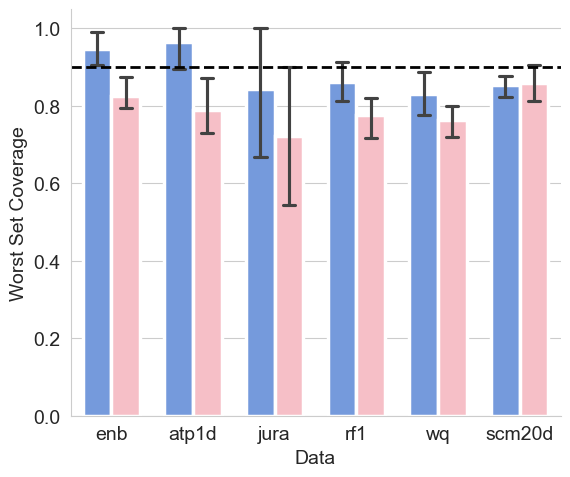

<Figure size 640x480 with 0 Axes>

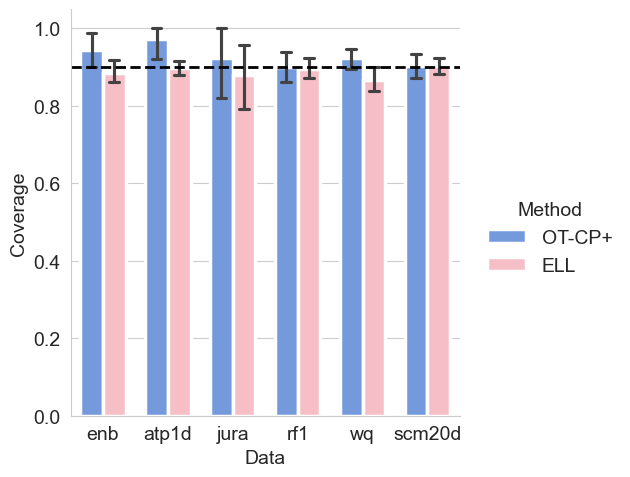

<Figure size 640x480 with 0 Axes>

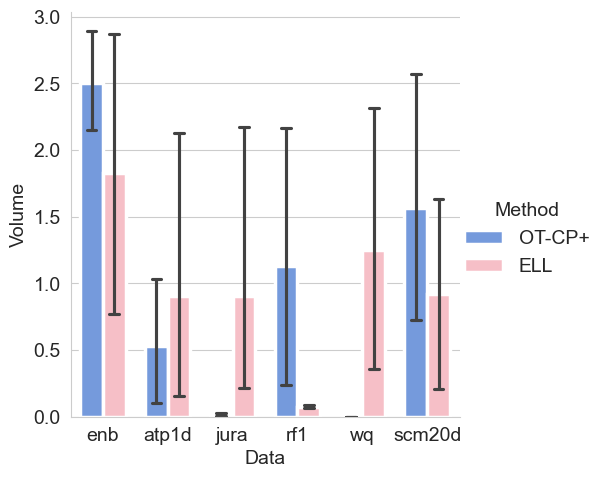

<Figure size 640x480 with 0 Axes>

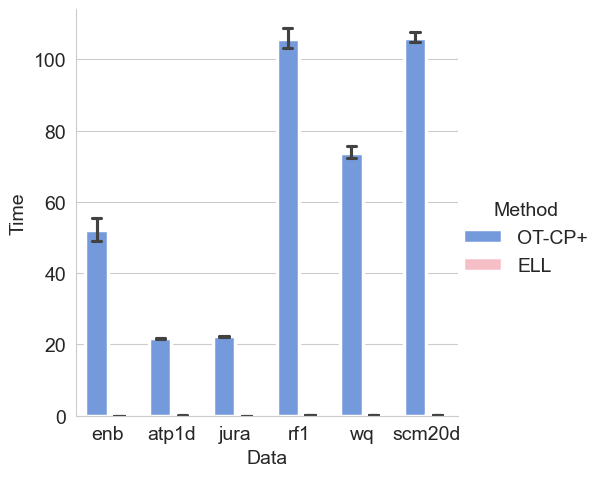

In [22]:
df_results_coverage = pd.read_csv('csv/reg_mediumdata_realdata_WorstCoverages.csv') 
df_results_coverage = pd.DataFrame(np.array(df_results_coverage),columns=["Worst Set Coverage","Method","Data"]) 

plt.figure()
g =sns.catplot( 
        data=df_results_coverage,  kind="bar",
        x="Data", y="Worst Set Coverage", hue="Method", palette=["cornflowerblue","lightpink"],height=5,width=0.7,capsize=0.3,aspect=1.2,linewidth=2.5,legend=["OT-CP","ELL"]
)   
g._legend.remove()
g.refline(y=alpha, color='black',linestyle="dashed",linewidth=2)
plt.savefig("Figures/RealData_RegressionConditionalCoverage.pdf", format="pdf",bbox_inches="tight") 

#############################################################################################
df_results_coverage2 = pd.read_csv('csv/reg_mediumdata_realdata_MarginalCoverages.csv') 
df_results_coverage2 = pd.DataFrame(np.array(df_results_coverage2),columns=["Coverage","Method","Data"]) 

plt.figure()
g =sns.catplot( 
        data=df_results_coverage2,  kind="bar",
        x="Data", y="Coverage", hue="Method", palette=["cornflowerblue","lightpink"],height=5,width=0.7,capsize=0.3,aspect=1,linewidth=2.5,legend=["OT-CP+","ELL"]
)   
g.refline(y=alpha, color='black',linestyle="dashed",linewidth=2)
plt.savefig("Figures/RealData_RegressionCoverage.pdf", format="pdf",bbox_inches="tight") 
#############################################################################################

df_results_volume = pd.read_csv('csv/reg_mediumdata_realdata_Volumes.csv') 
df_results_volume = pd.DataFrame(np.array(df_results_volume),columns=["Volume","Method","Data"]) 

for dataname in ["enb","atp1d","jura","rf1","wq","scm20d"]:
    normconstant = np.var(df_results_volume[df_results_volume["Data"]==dataname]["Volume"])**(1/2)
    print(normconstant)
    df_results_volume.loc[df_results_volume["Data"]==dataname,"Volume"] = df_results_volume.loc[df_results_volume["Data"]==dataname,"Volume"] /normconstant

plt.figure()
g =sns.catplot( 
        data=df_results_volume,  kind="bar",
        x="Data", y="Volume", hue="Method", palette=["cornflowerblue","lightpink"],height=5,width=0.7,capsize=0.3,aspect=1,linewidth=2.5,legend=["OT-CP+","ELL"]
)   
plt.savefig("Figures/RealData_RegressionVolume.pdf", format="pdf",bbox_inches="tight") 
#############################################################################################
df_results_time = pd.read_csv('csv/reg_mediumdata_realdata_time.csv') 
df_results_time = pd.DataFrame(np.array(df_results_time),columns=["Time","Method","Data"]) 

plt.figure()
g =sns.catplot( 
        data=df_results_time,  kind="bar",
        x="Data", y="Time", hue="Method", palette=["cornflowerblue","lightpink"],height=5,width=0.7,capsize=0.3,aspect=1,linewidth=2.5,legend=["OT-CP+","ELL"]
)   
plt.savefig("Figures/RealData_RegressionTime.pdf", format="pdf",bbox_inches="tight") 

# Other datasets that are in csv format: 

In [72]:
list_data = ["ansur2","bio","air","births1","taxi","households"] #(csv format)
dim_targets =  [2,2,2,2,6,2,2,4] 
m = 0
pd.read_csv('data/{}.csv'.format(list_data[m]) ).head(),pd.read_csv('data/{}.csv'.format(list_data[m]) ).shape

(   stature  footlength  tibialheight
 0     1560         246           430
 1     1665         249           475
 2     1711         265           458
 3     1660         265           463
 4     1572         247           429,
 (1986, 3))

In [ ]:
np.random.seed(567)

########### LOAD DATA 

list_data = ["ansur2","bio","air","births1","taxi","households"] #(csv format) 
dim_targets =  [2,2,6,2,2,4] 

alpha = 0.9 
t0 = time() 

Nrep = 5 

list_RESULTS_coverage = [] 
list_RESULTS_coverage2 = [] 
list_RESULTS_volume = [] 
list_RESULTS_time = [] 

for m in range(len(dim_targets)):
    # Load data 
    try:
        arff_file = arff.loadarff('./data/{}.arff'.format(list_data[m])) 
        df = pd.DataFrame(arff_file[0]).dropna()
    except:
        df = pd.read_csv('data/{}.csv'.format(list_data[m]) ) 

    # Separate explanatory and target variable (x,y) 
    df = np.array(df) 
    tt = df.shape[1] - dim_targets[m]
    x = df[:1500,:tt] 
    y = df[:1500,tt:] 
    print("size calibration data:",x.shape[0]/4)

    # For robust results, repeat 'Nrep' times a random splitting of the data 
    WorstCoverage_rep = -np.ones(Nrep) 
    Average_volume_rep =  -np.ones(Nrep) 
    WorstCoverage_rep_ell =  -np.ones(Nrep) 
    Average_volume_rep_ell = -np.ones(Nrep) 
    MarginalCoverage = - np.ones(Nrep) 
    MarginalCoverage_ell = -np.ones(Nrep) 
    timeMK = -np.ones(Nrep) 
    timeELL = -np.ones(Nrep) 

    for rep in range(Nrep): 
        print(m,rep,":",np.round(time()-t0,3) )
        #######################################
        ## Split Train / Calibration / Test 
        #######################################
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
        X_test, X_cal, y_test, y_cal = train_test_split(X_test, y_test, test_size=0.5)

        ## Learn regressor on Train data 
        model = RandomForestRegressor()
        model.fit(X_train,y_train)

        ## Evaluate scores on Calibration data and on Test data 
        y_pred_cal = model.predict(X_cal) 
        S_cal = y_cal - y_pred_cal 
        y_pred_test = model.predict(X_test) 
        Stest = y_test - y_pred_test 

        ## Choose a number of neighbors for KNN. Both methods use this, to estimate conditional distribution Y/X=x.
        n_neighbors = int(len(X_cal)*0.1) #int(len(X_cal)**0.5) 

        #######################################
        # MARGINAL COVERAGE : 
        #######################################
        NumberTestDataSet = len(X_test) # With low-medium datasets, this is the appropriate choice. You may take less than len(X_test) to accelerate testing computations (there is one OT problem for each Xtest, each OT problem being between point clouds with n_neighbors points)
        indices = np.random.choice(len(X_test),NumberTestDataSet )
        Stest = Stest[indices]
        y_test = y_test[indices]
        X_test = X_test[indices]
        y_pred_test = y_pred_test[indices]

        ## COMPUTE MK quantiles on calibration data and get metrics on test data 
        t0 = time()
        parameters_MK = functions.MultivQuantileTreshold_Adaptive(S_cal,X_cal,n_neighbors,alpha)
        MarginalCoverage[rep],Average_volume_rep[rep] = SetCoverage(X_test,Stest,parameters_MK)
        timeMK[rep] = np.round(time() - t0,3)
        ## COMPUTE ELLIPSOIDS on calibration data and get metrics on test data 
        lam = 0.95 # lambda parameter in their paper 
        t0 = time()
        cov_train,knn_ELL, local_alpha_s, indices_split1 = get_params_localEllipsoids(X_cal,y_cal,y_pred_cal,alpha,n_neighbors) 
        parameters_ell = [local_alpha_s,lam,cov_train,knn_ELL,y_pred_cal,y_cal,indices_split1]
        MarginalCoverage_ell[rep], Average_volume_rep_ell[rep] = SetCoverage_ell(X_test,y_test,y_pred_test,parameters_ell) 
        timeELL[rep] = np.round(time() - t0,3)                 
        ########################################
        # WORST SET COVERAGE : 
        ########################################
        ## Choose a number of neighbors for subsets Ai, when computing Worst Set coverage. 
        nn = int(len(X_cal)*0.2) # size of the five subsets to compute worst set coverage 
        WorstCoverage_rep[rep], average_volume_Ai = WorstSetCoverage(X_test,Stest,parameters_MK,n=nn)
        ## Compute Local ellipsoidal scores on calibration data and get metrics on test data 
        lam = 0.95 # lambda parameter in their paper 
        WorstCoverage_rep_ell[rep], normalized_ellipse_efficiency = WorstSetCoverage_Ellipsoids(X_test,y_test,y_pred_test,parameters_ell,nn=nn) 

    # For each data, we gather the results in a suitable form for future visualisations 
    WorstCoverages = np.concatenate([WorstCoverage_rep,WorstCoverage_rep_ell])
    methods = np.concatenate([np.repeat("OT-CP+",Nrep),np.repeat("ELL",Nrep)])
    name_data = np.repeat(list_data[m],Nrep*2)
    df1 = np.array([WorstCoverages,methods,name_data]).T 
    list_RESULTS_coverage.append( df1 )

    MarginalCoverages = np.concatenate([MarginalCoverage,MarginalCoverage_ell])
    df1 = np.array([MarginalCoverages,methods,name_data]).T 
    list_RESULTS_coverage2.append( df1 )

    Volumes = np.concatenate([Average_volume_rep,Average_volume_rep_ell])
    df2 = np.array([Volumes,methods,name_data]).T 
    list_RESULTS_volume.append( df2 )

    Times = np.concatenate([timeMK,timeELL])
    df2 = np.array([Times,methods,name_data]).T 
    list_RESULTS_time.append(df2)
    
    print(m,":",np.round(time()-t0,3) )

#############################################
# SAVE RESULTS : 
#############################################

######### Worst Set Coverage 
df_results_coverage = list_RESULTS_coverage[0] 
for i in range(1,len(list_RESULTS_coverage)):
    df_results_coverage = np.concatenate([df_results_coverage,list_RESULTS_coverage[i] ])
df_results_coverage = pd.DataFrame(df_results_coverage,columns=["Worst Set Coverage","Method","Data"])
df_results_coverage = df_results_coverage.astype({'Worst Set Coverage': 'float'})

######### Marginal Coverage  
df_results_coverage2 = list_RESULTS_coverage2[0] 
for i in range(1,len(list_RESULTS_coverage2)):
    df_results_coverage2 = np.concatenate([df_results_coverage2,list_RESULTS_coverage2[i] ])
df_results_coverage2 = pd.DataFrame(df_results_coverage2,columns=["Coverage","Method","Data"])
df_results_coverage2 = df_results_coverage2.astype({'Coverage': 'float'})

######### Average volume
df_results_volume= list_RESULTS_volume[0] 
for i in range(1,len(list_RESULTS_volume)):
    df_results_volume = np.concatenate([df_results_volume,list_RESULTS_volume[i] ])
df_results_volume = pd.DataFrame(df_results_volume,columns=["Volume","Method","Data"]) 
df_results_volume = df_results_volume.astype({'Volume': 'float'}) 

######### Computational time 
df_results_time = list_RESULTS_time[0] 
for i in range(1,len(list_RESULTS_time)):
    df_results_time = np.concatenate([df_results_time,list_RESULTS_time[i] ])
df_results_time = pd.DataFrame(df_results_time,columns=["Time","Method","Data"]) 
df_results_time = df_results_time.astype({'Time': 'float'}) 

#################
# We save the results 
df_results_coverage.to_csv('csv/reg_mediumdata_realdata_WorstCoverages2.csv', index=False) 
df_results_coverage2.to_csv('csv/reg_mediumdata_realdata_MarginalCoverages2.csv', index=False) 
df_results_volume.to_csv('csv/reg_mediumdata_realdata_Volumes2.csv', index=False) 
df_results_time.to_csv('csv/reg_mediumdata_realdata_time2.csv', index=False) 


size calibration data: 375.0
0 0 : 0.114
0 1 : 97.541
0 2 : 8861.418
0 3 : 92.554
0 4 : 463.158
0 : 101.693
size calibration data: 375.0
1 0 : 101.749
1 1 : 101.144
1 2 : 101.976
1 3 : 97.447
1 4 : 100.932
1 : 102.556
size calibration data: 375.0
2 0 : 102.711
2 1 : 111.45
2 2 : 105.954
2 3 : 107.032
2 4 : 105.234
2 : 106.476
size calibration data: 375.0
3 0 : 106.49
3 1 : 106.838
3 2 : 106.869
3 3 : 94.97
3 4 : 98.97
3 : 99.236
size calibration data: 375.0
4 0 : 99.452
4 1 : 98.961
4 2 : 99.49
4 3 : 104.885
4 4 : 104.875
4 : 105.145
size calibration data: 375.0
5 0 : 105.158
5 1 : 107.711
5 2 : 108.737
5 3 : 109.749
5 4 : 108.75
5 : 110.06


229.60901305774127
363.0030771210645
11398.454948286604
7791.47166318362
0.005535272697222174
1.0993100525497354e+17


<Figure size 640x480 with 0 Axes>

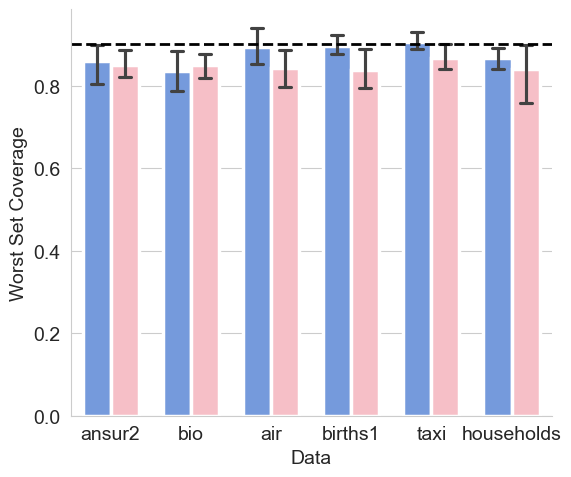

<Figure size 640x480 with 0 Axes>

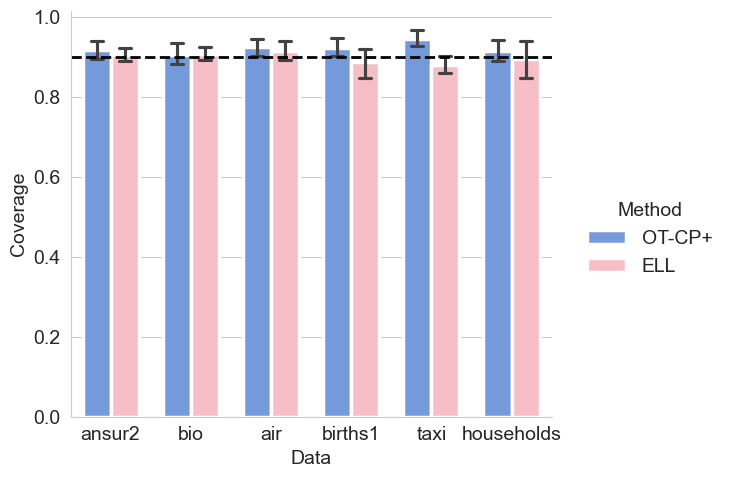

<Figure size 640x480 with 0 Axes>

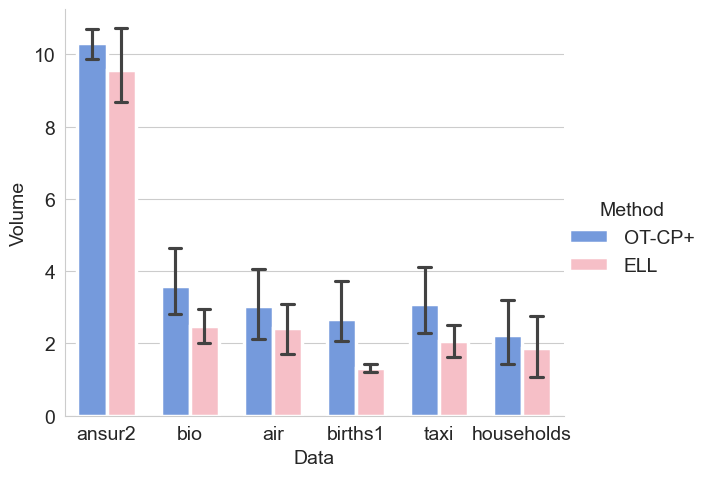

<Figure size 640x480 with 0 Axes>

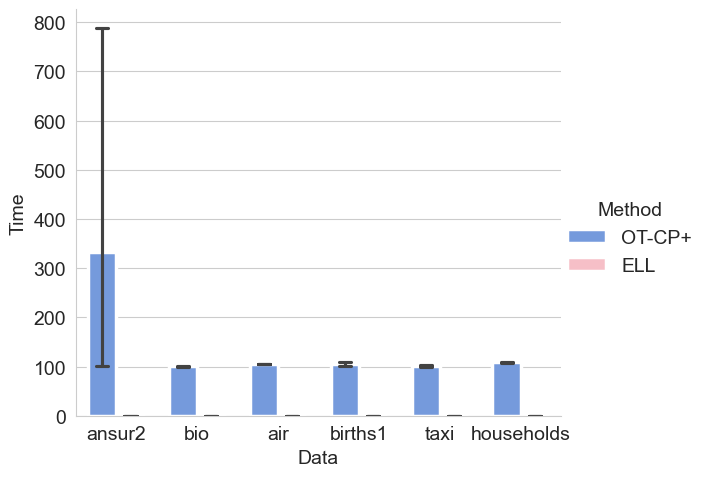

In [73]:
df_results_coverage = pd.read_csv('csv/reg_mediumdata_realdata_WorstCoverages2.csv') 
df_results_coverage = pd.DataFrame(np.array(df_results_coverage),columns=["Worst Set Coverage","Method","Data"]) 

plt.figure()
g =sns.catplot( 
        data=df_results_coverage,  kind="bar",
        x="Data", y="Worst Set Coverage", hue="Method", palette=["cornflowerblue","lightpink"],height=5,width=0.7,capsize=0.3,aspect=1.2,linewidth=2.5,legend=["OT-CP","ELL"]
)   
g._legend.remove()
g.refline(y=alpha, color='black',linestyle="dashed",linewidth=2)
plt.savefig("Figures/RealData_RegressionConditionalCoverage2.pdf", format="pdf",bbox_inches="tight") 

#############################################################################################
df_results_coverage2 = pd.read_csv('csv/reg_mediumdata_realdata_MarginalCoverages2.csv') 
df_results_coverage2 = pd.DataFrame(np.array(df_results_coverage2),columns=["Coverage","Method","Data"]) 

plt.figure()
g =sns.catplot( 
        data=df_results_coverage2,  kind="bar",
        x="Data", y="Coverage", hue="Method", palette=["cornflowerblue","lightpink"],height=5,width=0.7,capsize=0.3,aspect=1.2,linewidth=2.5,legend=["OT-CP+","ELL"]
)   
g.refline(y=alpha, color='black',linestyle="dashed",linewidth=2)
plt.savefig("Figures/RealData_RegressionCoverage2.pdf", format="pdf",bbox_inches="tight") 
#############################################################################################

df_results_volume = pd.read_csv('csv/reg_mediumdata_realdata_Volumes2.csv') 
df_results_volume = pd.DataFrame(np.array(df_results_volume),columns=["Volume","Method","Data"]) 

for dataname in ["ansur2","bio","air","births1","taxi","households"]:
    normconstant = np.var(df_results_volume[df_results_volume["Data"]==dataname]["Volume"])**(1/2)
    print(normconstant)
    df_results_volume.loc[df_results_volume["Data"]==dataname,"Volume"] = df_results_volume.loc[df_results_volume["Data"]==dataname,"Volume"] /normconstant


plt.figure()
g =sns.catplot( 
        data=df_results_volume,  kind="bar",
        x="Data", y="Volume", hue="Method", palette=["cornflowerblue","lightpink"],height=5,width=0.7,capsize=0.3,aspect=1.2,linewidth=2.5,legend=["OT-CP+","ELL"]
)   
plt.savefig("Figures/RealData_RegressionVolume2.pdf", format="pdf",bbox_inches="tight") 
#############################################################################################
df_results_time = pd.read_csv('csv/reg_mediumdata_realdata_time2.csv') 
df_results_time = pd.DataFrame(np.array(df_results_time),columns=["Time","Method","Data"]) 

plt.figure()
g =sns.catplot( 
        data=df_results_time,  kind="bar",
        x="Data", y="Time", hue="Method", palette=["cornflowerblue","lightpink"],height=5,width=0.7,capsize=0.3,aspect=1.2,linewidth=2.5,legend=["OT-CP+","ELL"]
)   
plt.savefig("Figures/RealData_RegressionTime2.pdf", format="pdf",bbox_inches="tight") 

# Setting with more samples : 
## Two datasets of nearly 9000 observations

In [74]:
np.random.seed(567) 

########### LOAD DATA 
list_data = ["rf1","scm20d"] 
dim_targets = [8,16] 

alpha = 0.9 
t0 = time() 

Nrep = 5 

list_RESULTS_coverage = []
list_RESULTS_coverage2 = []
list_RESULTS_volume = []
list_RESULTS_time = []

for m in range(len(dim_targets)):
    # Load data 
    try:
        arff_file = arff.loadarff('./data/{}.arff'.format(list_data[m])) 
        df = pd.DataFrame(arff_file[0]).dropna()
    except:
        df = pd.read_csv('data/{}.csv'.format(list_data[m]) ) 

    # Separate explanatory and target variable (x,y) 
    df = np.array(df) 
    tt = df.shape[1] - dim_targets[m]
    x = df[:,:tt] 
    y = df[:,tt:] 
    print("size calibration data:",x.shape[0]/4)

    # For robust results, repeat 'Nrep' times a random splitting of the data 
    WorstCoverage_rep = -np.ones(Nrep) 
    Average_volume_rep =  -np.ones(Nrep) 
    WorstCoverage_rep_ell =  -np.ones(Nrep) 
    Average_volume_rep_ell = -np.ones(Nrep) 
    MarginalCoverage = - np.ones(Nrep) 
    MarginalCoverage_ell = -np.ones(Nrep) 
    timeMK = -np.ones(Nrep) 
    timeELL = -np.ones(Nrep) 

    for rep in range(Nrep): 
        print(m,rep,":",np.round(time()-t0,3) )
        #######################################
        ## Split Train / Calibration / Test 
        #######################################
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
        X_test, X_cal, y_test, y_cal = train_test_split(X_test, y_test, test_size=0.5)

        ## Learn regressor on Train data 
        model = RandomForestRegressor()
        model.fit(X_train,y_train)

        ## Evaluate scores on Calibration data and on Test data 
        y_pred_cal = model.predict(X_cal) 
        S_cal = y_cal - y_pred_cal 
        y_pred_test = model.predict(X_test) 
        Stest = y_test - y_pred_test 

        ## Choose a number of neighbors for KNN. Both methods use this, to estimate conditional distribution Y/X=x.
        n_neighbors = int(len(X_cal)**(0.5)) 

        #######################################
        # MARGINAL COVERAGE : 
        #######################################
        NumberTestDataSet = int(len(X_test)/2) # With low-medium datasets, len(X_test) is the appropriate choice. But less than len(X_test) do accelerate computations for testing (there is one OT problem for each Xtest, each OT problem being between point clouds with n_neighbors points)
        indices = np.random.choice(len(X_test),NumberTestDataSet )
        Stest = Stest[indices]
        y_test = y_test[indices]
        X_test = X_test[indices]
        y_pred_test = y_pred_test[indices]

        ## COMPUTE MK quantiles on calibration data and get metrics on test data 
        t0 = time()
        parameters_MK = functions.MultivQuantileTreshold_Adaptive(S_cal,X_cal,n_neighbors,alpha)
        MarginalCoverage[rep],Average_volume_rep[rep] = SetCoverage(X_test,Stest,parameters_MK)
        timeMK[rep] = np.round(time() - t0,3)
        ## COMPUTE ELLIPSOIDS on calibration data and get metrics on test data 
        lam = 0.95 # lambda parameter in their paper 
        t0 = time()
        cov_train,knn_ELL, local_alpha_s, indices_split1 = get_params_localEllipsoids(X_cal,y_cal,y_pred_cal,alpha,n_neighbors) 
        parameters_ell = [local_alpha_s,lam,cov_train,knn_ELL,y_pred_cal,y_cal,indices_split1]
        MarginalCoverage_ell[rep], Average_volume_rep_ell[rep] = SetCoverage_ell(X_test,y_test,y_pred_test,parameters_ell) 
        timeELL[rep] = np.round(time() - t0,3)                 
        ########################################
        # WORST SET COVERAGE : 
        ########################################
        ## Choose a number of neighbors for subsets Ai, when computing Worst Set coverage. 
        nn = int(len(X_cal)*0.1) # size of the five subsets to compute worst set coverage 
        WorstCoverage_rep[rep], average_volume_Ai = WorstSetCoverage(X_test,Stest,parameters_MK,n=nn)
        ## Compute Local ellipsoidal scores on calibration data and get metrics on test data 
        WorstCoverage_rep_ell[rep], normalized_ellipse_efficiency = WorstSetCoverage_Ellipsoids(X_test,y_test,y_pred_test,parameters_ell,nn=nn) 

    # For each data, we gather the results in a suitable form for future visualisations 
    WorstCoverages = np.concatenate([WorstCoverage_rep,WorstCoverage_rep_ell])
    methods = np.concatenate([np.repeat("OT-CP+",Nrep),np.repeat("ELL",Nrep)])
    name_data = np.repeat(list_data[m],Nrep*2)
    df1 = np.array([WorstCoverages,methods,name_data]).T 
    list_RESULTS_coverage.append( df1 )

    MarginalCoverages = np.concatenate([MarginalCoverage,MarginalCoverage_ell])
    df1 = np.array([MarginalCoverages,methods,name_data]).T 
    list_RESULTS_coverage2.append( df1 )

    Volumes = np.concatenate([Average_volume_rep,Average_volume_rep_ell])
    df2 = np.array([Volumes,methods,name_data]).T 
    list_RESULTS_volume.append( df2 )

    Times = np.concatenate([timeMK,timeELL])
    df2 = np.array([Times,methods,name_data]).T 
    list_RESULTS_time.append(df2)
    
    print(m,":",np.round(time()-t0,3) )

#############################################
# SAVE RESULTS : 
#############################################

######### Worst Set Coverage 
df_results_coverage = list_RESULTS_coverage[0] 
for i in range(1,len(list_RESULTS_coverage)):
    df_results_coverage = np.concatenate([df_results_coverage,list_RESULTS_coverage[i] ])
df_results_coverage = pd.DataFrame(df_results_coverage,columns=["Worst Set Coverage","Method","Data"])
df_results_coverage = df_results_coverage.astype({'Worst Set Coverage': 'float'})

######### Marginal Coverage  
df_results_coverage2 = list_RESULTS_coverage2[0] 
for i in range(1,len(list_RESULTS_coverage2)):
    df_results_coverage2 = np.concatenate([df_results_coverage2,list_RESULTS_coverage2[i] ])
df_results_coverage2 = pd.DataFrame(df_results_coverage2,columns=["Coverage","Method","Data"])
df_results_coverage2 = df_results_coverage2.astype({'Coverage': 'float'})

######### Average volume
df_results_volume= list_RESULTS_volume[0] 
for i in range(1,len(list_RESULTS_volume)):
    df_results_volume = np.concatenate([df_results_volume,list_RESULTS_volume[i] ])
df_results_volume = pd.DataFrame(df_results_volume,columns=["Volume","Method","Data"]) 
df_results_volume = df_results_volume.astype({'Volume': 'float'}) 

######### Computational time 
df_results_time = list_RESULTS_time[0] 
for i in range(1,len(list_RESULTS_time)):
    df_results_time = np.concatenate([df_results_time,list_RESULTS_time[i] ])
df_results_time = pd.DataFrame(df_results_time,columns=["Time","Method","Data"]) 
df_results_time = df_results_time.astype({'Time': 'float'}) 

#################
# We save the results 
df_results_coverage.to_csv('csv/reg_manypoints_realdata_WorstCoverages.csv', index=False) 
df_results_coverage2.to_csv('csv/reg_manypoints_realdata_MarginalCoverages.csv', index=False) 
df_results_volume.to_csv('csv/reg_manypoints_realdata_Volumes.csv', index=False) 
df_results_time.to_csv('csv/reg_manypoints_realdata_time.csv', index=False) 


size calibration data: 2251.25
0 0 : 0.192
0 1 : 217.095
0 2 : 201.883
0 3 : 208.801
0 4 : 214.945
0 : 217.229
size calibration data: 2241.5
1 0 : 217.55
1 1 : 389.649
1 2 : 484.071
1 3 : 395.368
1 4 : 350.828
1 : 337.184


2

<Figure size 640x480 with 0 Axes>

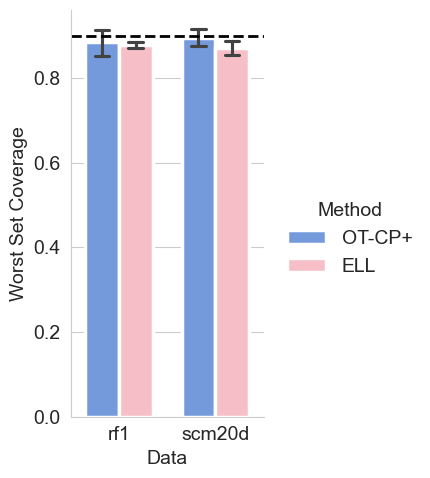

<Figure size 640x480 with 0 Axes>

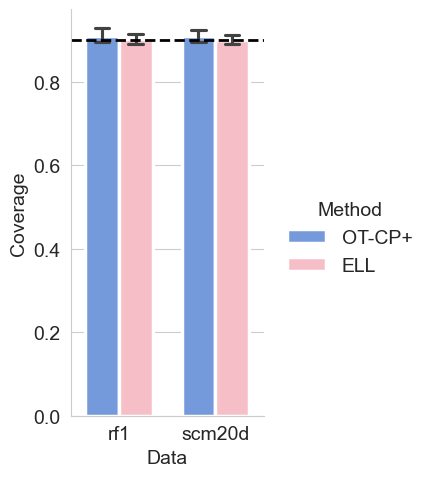

<Figure size 640x480 with 0 Axes>

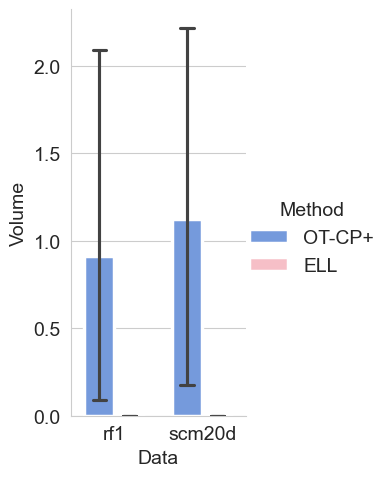

<Figure size 640x480 with 0 Axes>

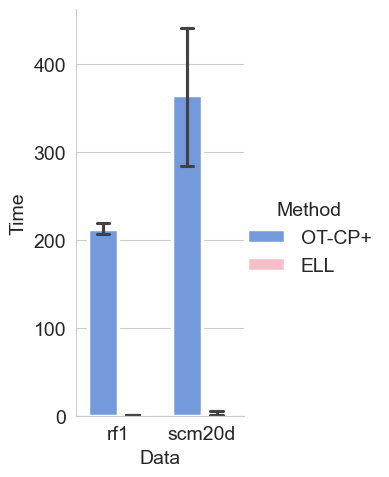

In [79]:
df_results_coverage = pd.read_csv('csv/reg_manypoints_realdata_WorstCoverages.csv') 
df_results_coverage = pd.DataFrame(np.array(df_results_coverage),columns=["Worst Set Coverage","Method","Data"]) 

plt.figure()
g =sns.catplot( 
        data=df_results_coverage,  kind="bar",
        x="Data", y="Worst Set Coverage", hue="Method", palette=["cornflowerblue","lightpink"],height=5,width=0.7,capsize=0.3,aspect=0.6,linewidth=2.5,legend=["OT-CP","ELL"]
)   
g.refline(y=alpha, color='black',linestyle="dashed",linewidth=2)
plt.savefig("Figures/Realmanypoints_RegressionConditionalCoverage.pdf", format="pdf",bbox_inches="tight") 

#############################################################################################
df_results_coverage2 = pd.read_csv('csv/reg_manypoints_realdata_MarginalCoverages.csv') 
df_results_coverage2 = pd.DataFrame(np.array(df_results_coverage2),columns=["Coverage","Method","Data"]) 

plt.figure()
g =sns.catplot( 
        data=df_results_coverage2,  kind="bar",
        x="Data", y="Coverage", hue="Method", palette=["cornflowerblue","lightpink"],height=5,width=0.7,capsize=0.3,aspect=0.6,linewidth=2.5,legend=["OT-CP+","ELL"]
)   
g.refline(y=alpha, color='black',linestyle="dashed",linewidth=2)
plt.savefig("Figures/Realmanypoints_RegressionCoverage.pdf", format="pdf",bbox_inches="tight") 
#############################################################################################

df_results_volume = pd.read_csv('csv/reg_manypoints_realdata_Volumes.csv') 
df_results_volume = pd.DataFrame(np.array(df_results_volume),columns=["Volume","Method","Data"]) 

for dataname in ["rf1","scm20d"]:
    normconstant = np.var(df_results_volume[df_results_volume["Data"]==dataname]["Volume"])**(1/2)
    df_results_volume.loc[df_results_volume["Data"]==dataname,"Volume"] = df_results_volume.loc[df_results_volume["Data"]==dataname,"Volume"] /normconstant


plt.figure()
g =sns.catplot( 
        data=df_results_volume,  kind="bar",
        x="Data", y="Volume", hue="Method", palette=["cornflowerblue","lightpink"],height=5,width=0.7,capsize=0.3,aspect=.6,linewidth=2.5,legend=["OT-CP+","ELL"]
)   
plt.savefig("Figures/Realmanypoints_RegressionVolume.pdf", format="pdf",bbox_inches="tight") 
#############################################################################################
df_results_time = pd.read_csv('csv/reg_manypoints_realdata_time.csv') 
df_results_time = pd.DataFrame(np.array(df_results_time),columns=["Time","Method","Data"]) 


plt.figure()
g =sns.catplot( 
        data=df_results_time,  kind="bar",
        x="Data", y="Time", hue="Method", palette=["cornflowerblue","lightpink"],height=5,width=0.7,capsize=0.3,aspect=.6,linewidth=2.5,legend=["OT-CP+","ELL"]
)   
plt.savefig("Figures/Realmanypoints_RegressionTime.pdf", format="pdf",bbox_inches="tight") 